In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
wanghaohan_confused_eeg_path = kagglehub.dataset_download('wanghaohan/confused-eeg')

print('Data source import complete.')


100%|██████████| 109M/109M [00:01<00:00, 65.5MB/s]

Extracting files...


Data source import complete.


# Exploratory Data Analysis and Model Improvement

## Introduction
This project aims to analyze EEG data, preprocess it, and apply various ensemble methods to improve model performance. The final goal is to compare these methods to determine the most effective technique for predicting confusion states in students while watching educational videos.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

In [3]:
file_path = wanghaohan_confused_eeg_path + '/EEG_data.csv'
data = pd.read_csv(file_path)
# data= pd.read_csv("/kaggle/input/confused-eeg/EEG_data.csv")
file_names = {
    0: 'physics_0.m4v',
    1: 'calculus_1.m4v',
    2: 'calculus_2.m4v',
    3: 'alegbra_3.m4v',
    4: 'alegbra_4.m4v',
    5: 'physics_5.m4v',
    6: 'Stem_Cell_6.m4v',
    7: 'analog_signals.m4v',
    8: 'digital_signals.m4v',
    9: 'audio_signals.m4v'
}
data['VideoID'] = data['VideoID'].map(file_names)
data.to_csv("EEG_confused.csv",index=False)

In [6]:
demo_df = pd.read_csv(wanghaohan_confused_eeg_path+"/demographic_info.csv")
print("================================================================= Demographic info =================================================================")
demo_df.head(10)

================================================================= Demographic info =================================================================


,subject ID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M
5,5,24,Han Chinese,M
6,6,24,Han Chinese,M
7,7,25,Han Chinese,M
8,8,25,Han Chinese,M
9,9,24,Han Chinese,F


In [7]:
eeg_df = pd.read_csv("EEG_confused.csv")
print("================================================================= EEG_data ==================================================================================== ")
eeg_df.head()


================================================================= EEG_data ==================================================================================== 


,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,physics_0.m4v,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,physics_0.m4v,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,physics_0.m4v,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,physics_0.m4v,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,physics_0.m4v,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [8]:
demo_df = demo_df.rename(columns = {'subject ID': 'SubjectID'})
demo_df

,SubjectID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M
5,5,24,Han Chinese,M
6,6,24,Han Chinese,M
7,7,25,Han Chinese,M
8,8,25,Han Chinese,M
9,9,24,Han Chinese,F


## Merging both datasets based on SubjectId

We merge the EEG data with demographic data based on the SubjectID column to enrich the dataset with additional features.

In [9]:
df = eeg_df.merge(demo_df,how = 'inner',on = 'SubjectID')
# Strip whitespace from column names
df.columns = df.columns.str.strip()


In [10]:
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,physics_0.m4v,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,physics_0.m4v,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,physics_0.m4v,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,physics_0.m4v,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,physics_0.m4v,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


# **Summary Statistics**


In [11]:
print("============================ Info: ============================ \n")
print(df.info())
print("================================================================================================ Desciption: ==========================================================================================================\n\n")
df.describe()

============================ Info: ============================ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  float64
 1   VideoID             12811 non-null  object 
 2   Attention           12811 non-null  float64
 3   Mediation           12811 non-null  float64
 4   Raw                 12811 non-null  float64
 5   Delta               12811 non-null  float64
 6   Theta               12811 non-null  float64
 7   Alpha1              12811 non-null  float64
 8   Alpha2              12811 non-null  float64
 9   Beta1               12811 non-null  float64
 10  Beta2               12811 non-null  float64
 11  Gamma1              12811 non-null  float64
 12  Gamma2              12811 non-null  float64
 13  predefinedlabel     12811 non-null  float64
 14  user-definedlabeln  12811 non-null  

,SubjectID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age
count,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000,12811.000000
mean,4.487394,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606,25.409960
std,2.865373,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861,2.205148
min,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000,24.000000
25%,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000,24.000000
50%,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000,25.000000
75%,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000,25.000000
max,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000,31.000000


<ipython-input-12-4f902582ba17>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', num_colors)


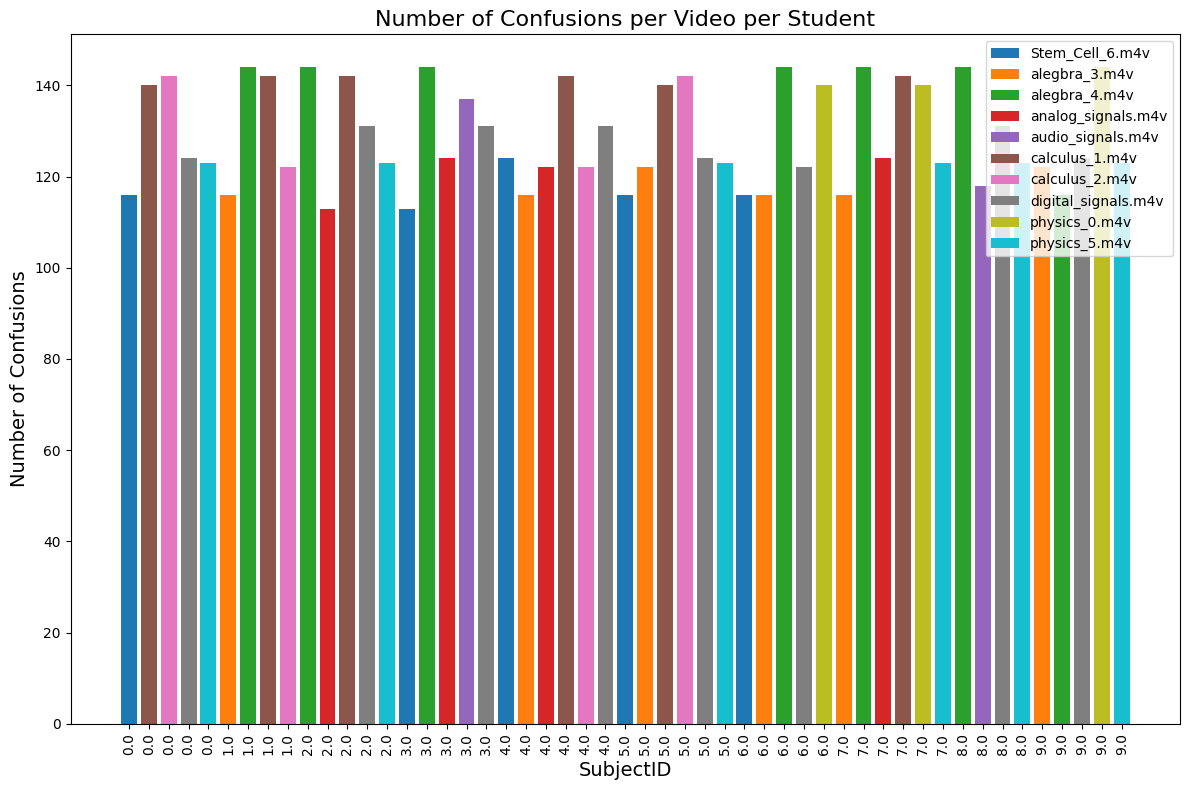

In [12]:
# Group by both SubjectID and VideoID and count confused segments
confusion_counts_per_video_per_student = df[df['user-definedlabeln'] == 1].groupby(['SubjectID', 'VideoID']).size().reset_index(name='confused_count')
unique_video_ids = confusion_counts_per_video_per_student['VideoID'].unique()
num_colors = len(unique_video_ids)
color_map = plt.cm.get_cmap('tab10', num_colors)

# Plot
plt.figure(figsize=(12, 8))
for idx, (video_id, group) in enumerate(confusion_counts_per_video_per_student.groupby('VideoID')):
    plt.bar(group.index, group['confused_count'], color=color_map(idx), label=video_id)

plt.xlabel('SubjectID', fontsize=14)
plt.ylabel('Number of Confusions', fontsize=14)
plt.title('Number of Confusions per Video per Student', fontsize=16)
plt.xticks(confusion_counts_per_video_per_student.index, confusion_counts_per_video_per_student['SubjectID'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Aggregate the data by VideoID
confusion_counts = df.groupby('VideoID')['user-definedlabeln'].sum().reset_index()

# Rename the columns for clarity
confusion_counts.columns = ['VideoID', 'Number of Time Video Confused Students']

# Display the aggregated data
print(confusion_counts)

               VideoID  Number of Time Video Confused Students
0      Stem_Cell_6.m4v                                   585.0
1        alegbra_3.m4v                                   708.0
2        alegbra_4.m4v                                   980.0
3   analog_signals.m4v                                   483.0
4    audio_signals.m4v                                   255.0
5       calculus_1.m4v                                   848.0
6       calculus_2.m4v                                   528.0
7  digital_signals.m4v                                  1018.0
8        physics_0.m4v                                   424.0
9        physics_5.m4v                                   738.0


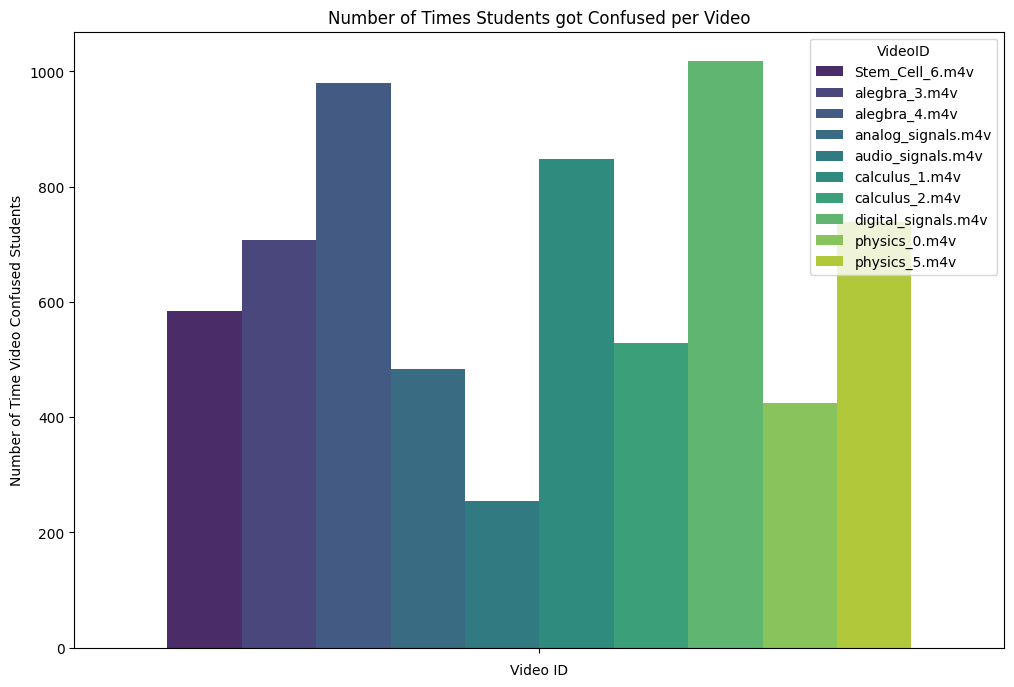

In [14]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create a bar plot
sns.barplot(data=confusion_counts, hue='VideoID', y='Number of Time Video Confused Students', palette='viridis')

# Customize the plot
plt.title('Number of Times Students got Confused per Video')
plt.xlabel('Video ID')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Time Video Confused Students')

# Display the plot
plt.show()

## Data Preprocessing and Feature Engineering

We identify and count the missing values in each column to understand the extent of missing data. But in our dataset we dont have any missing values.

We handle missing values using SimpleImputer with the mean strategy, as the number of missing values is small. This prevents data loss that could occur if we simply dropped rows or columns with missing values.

In [15]:
missing_values_count = df.isnull().sum()
columns_with_missing_values = missing_values_count[missing_values_count > 0].index.tolist()
if columns_with_missing_values :
    imputer = SimpleImputer(strategy='mean')
    df[columns_with_missing_values] = imputer.fit_transform(df[columns_with_missing_values])

    missing_values_count_after_imputation = df.isna().sum()
    columns_with_missing_values_after_imputation = missing_values_count_after_imputation[missing_values_count_after_imputation > 0].index.tolist()

    print("Columns with missing values after imputation:")
    print(columns_with_missing_values_after_imputation)
else:
  print("There is No missing value in dataset")


There is No missing value in dataset


In [16]:
# label encoders
ethnicity_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
videoid_encoder = LabelEncoder()

# Applying Label Encoding to 'ethnicity' and 'gender' columns
df['ethnicity'] = ethnicity_encoder.fit_transform(df['ethnicity'])
df['gender'] = gender_encoder.fit_transform(df['gender'])
df['VideoID'] = videoid_encoder.fit_transform(df['VideoID'])

print(df.head())

ethnicity_mapping = dict(zip(ethnicity_encoder.classes_, ethnicity_encoder.transform(ethnicity_encoder.classes_)))
gender_mapping = dict(zip(gender_encoder.classes_, gender_encoder.transform(gender_encoder.classes_)))
videoid_mapping = dict(zip(videoid_encoder.classes_, videoid_encoder.transform(videoid_encoder.classes_)))

print("\nEthnicity Mapping:")
print(ethnicity_mapping)

print("\nGender Mapping:")
print(gender_mapping)

print("\nVideoID Mapping:")
print(videoid_mapping)


   SubjectID  VideoID  Attention  Mediation    Raw      Delta     Theta  \
0        0.0        8       56.0       43.0  278.0   301963.0   90612.0   
1        0.0        8       40.0       35.0  -50.0    73787.0   28083.0   
2        0.0        8       47.0       48.0  101.0   758353.0  383745.0   
3        0.0        8       47.0       57.0   -5.0  2012240.0  129350.0   
4        0.0        8       44.0       53.0   -8.0  1005145.0  354328.0   

     Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  predefinedlabel  \
0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0              0.0   
1    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0              0.0   
2  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0              0.0   
3   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0              0.0   
4   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0              0.0   

   user-definedlabeln  age  ethnicity  gender  
0                 0.0   25      

We encode categorical variables (ethnicity, gender, VideoID) into numerical values to make them suitable for machine learning algorithms.

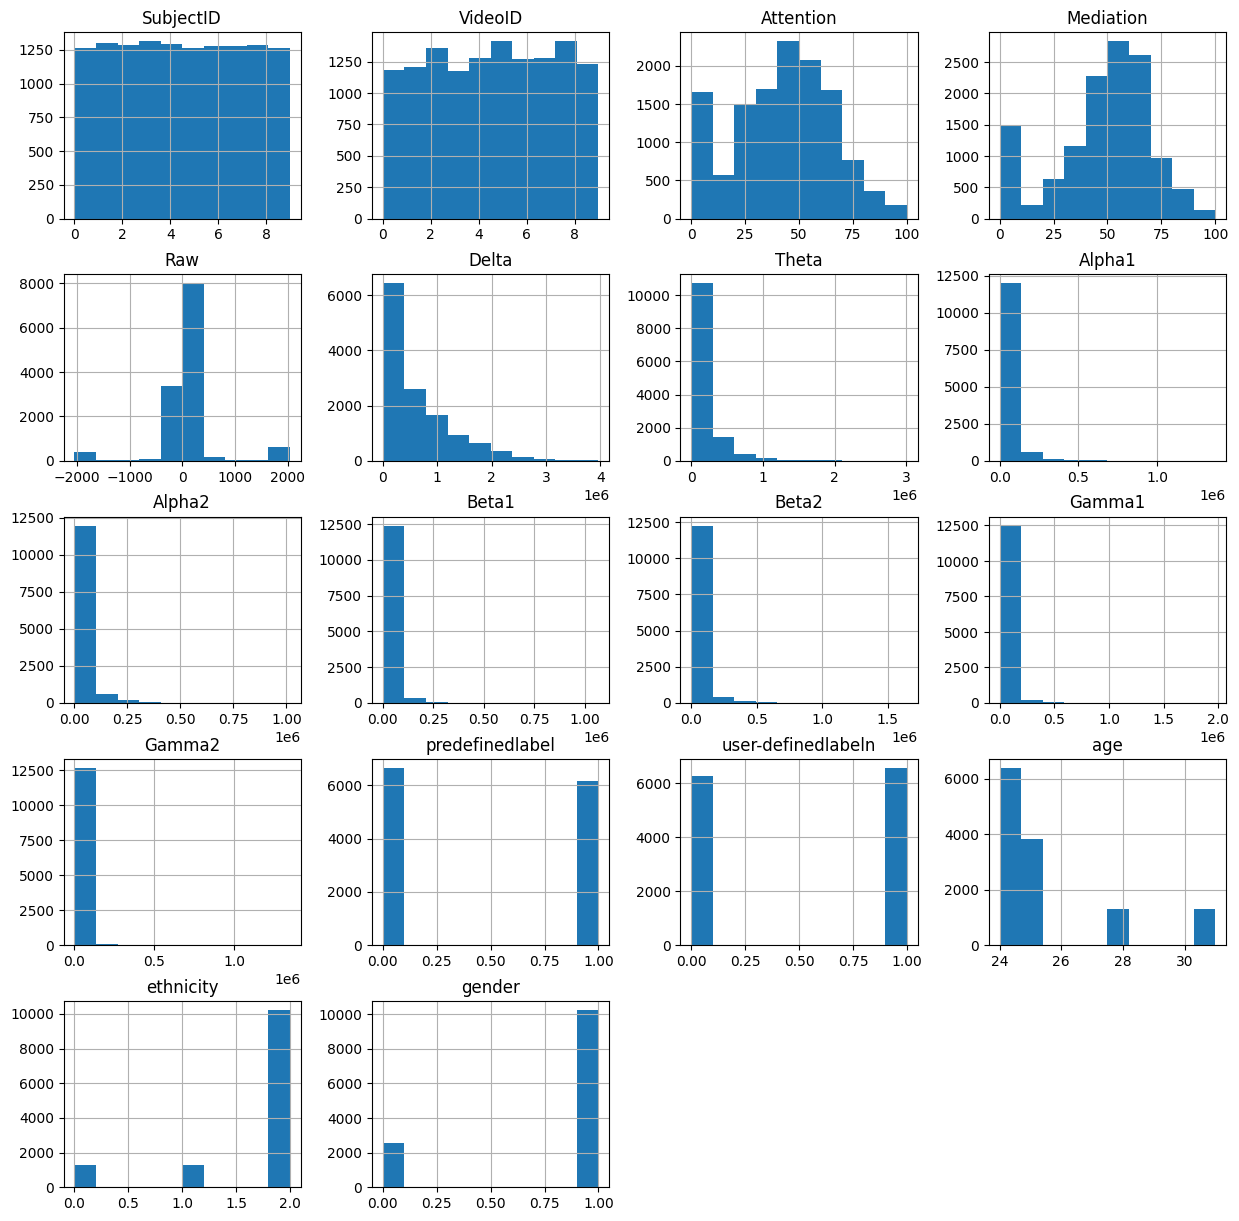

In [17]:
df.hist(figsize = (15,15))
plt.show()

### Before Outliers

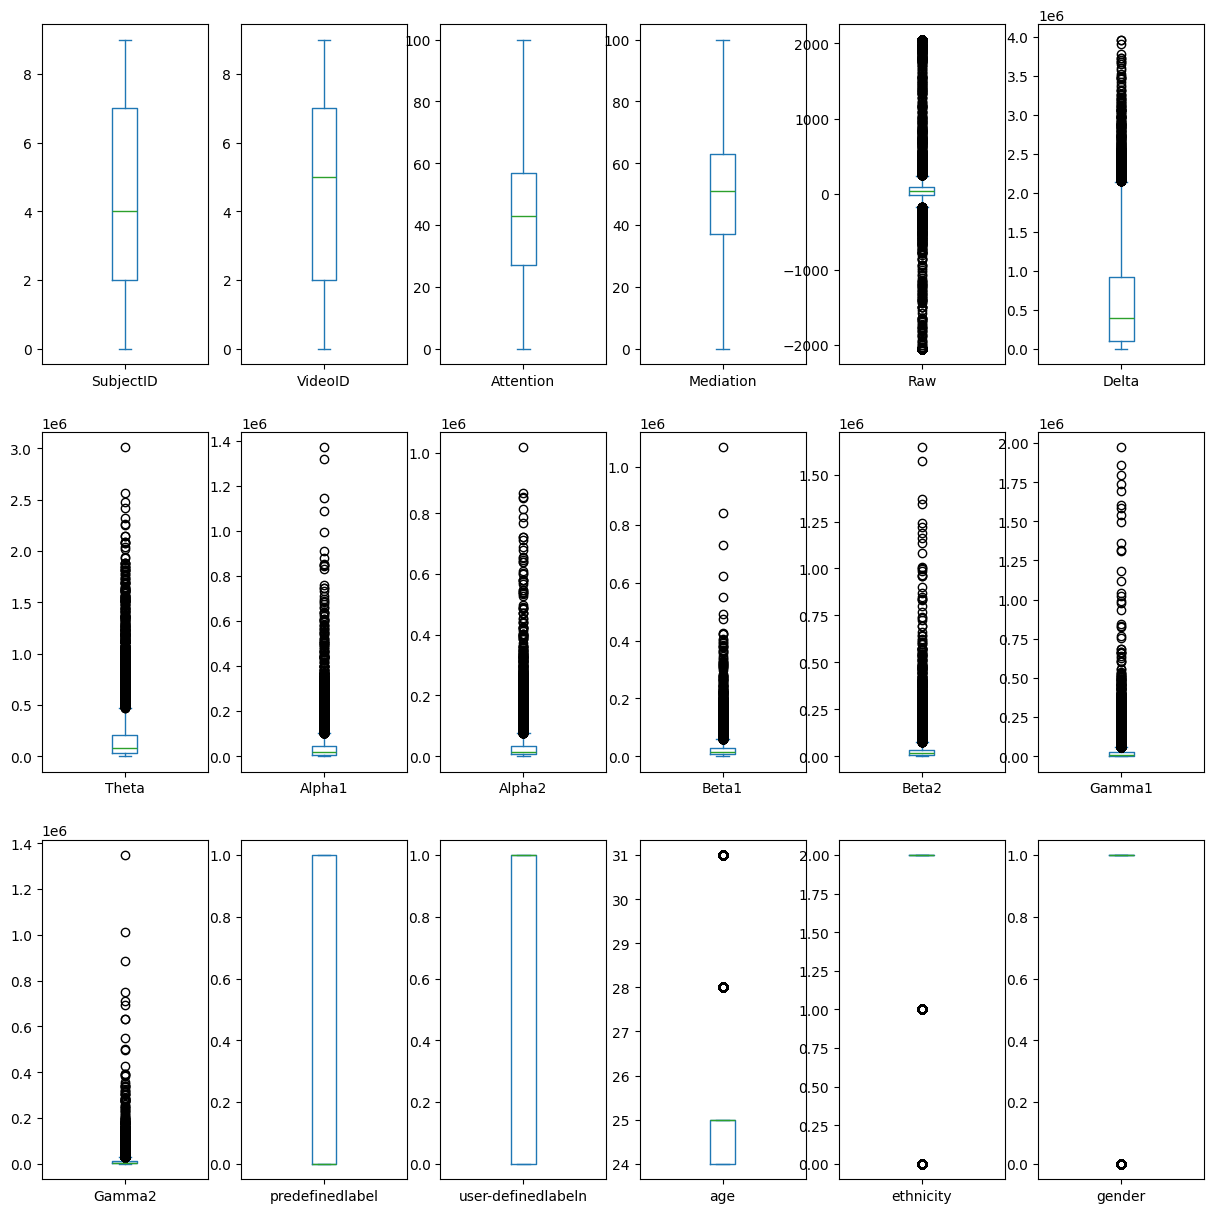

In [18]:
# Box-plot

data = df.copy()
data.plot(kind='box',figsize=(15,15),subplots=True,layout=(3,6))
plt.show()

## Handling Outliers
### We cap the values of numerical features at the 1st and 99th percentiles to mitigate the effect of outliers.

In [19]:
for feature in data:
    print(f"\nProcessing feature: {feature}")

    # Calculate the 1st and 99th percentiles for capping
    lower_percentile = data[feature].quantile(0.01)
    upper_percentile = data[feature].quantile(0.99)

    # Cap the outliers at the 1st and 99th percentiles
    data[feature] = np.where(data[feature] < lower_percentile, lower_percentile,
                             data[feature])
    data[feature] = np.where(data[feature] > upper_percentile, upper_percentile,
                             data[feature])

    print(f"Values for '{feature}' capped between {lower_percentile} and {upper_percentile}")



Processing feature: SubjectID
Values for 'SubjectID' capped between 0.0 and 9.0

Processing feature: VideoID
Values for 'VideoID' capped between 0.0 and 9.0

Processing feature: Attention
Values for 'Attention' capped between 0.0 and 91.0

Processing feature: Mediation
Values for 'Mediation' capped between 0.0 and 90.0

Processing feature: Raw
Values for 'Raw' capped between -2048.0 and 2047.0

Processing feature: Delta
Values for 'Delta' capped between 2733.3 and 2595771.8999999985

Processing feature: Theta
Values for 'Theta' capped between 3410.0 and 1253798.4999999958

Processing feature: Alpha1
Values for 'Alpha1' capped between 750.0 and 336929.29999999894

Processing feature: Alpha2
Values for 'Alpha2' capped between 981.3 and 277340.29999999976

Processing feature: Beta1
Values for 'Beta1' capped between 923.3 and 182545.19999999992

Processing feature: Beta2
Values for 'Beta2' capped between 1407.0 and 376426.29999999976

Processing feature: Gamma1
Values for 'Gamma1' capped 

### Outliers After Capped

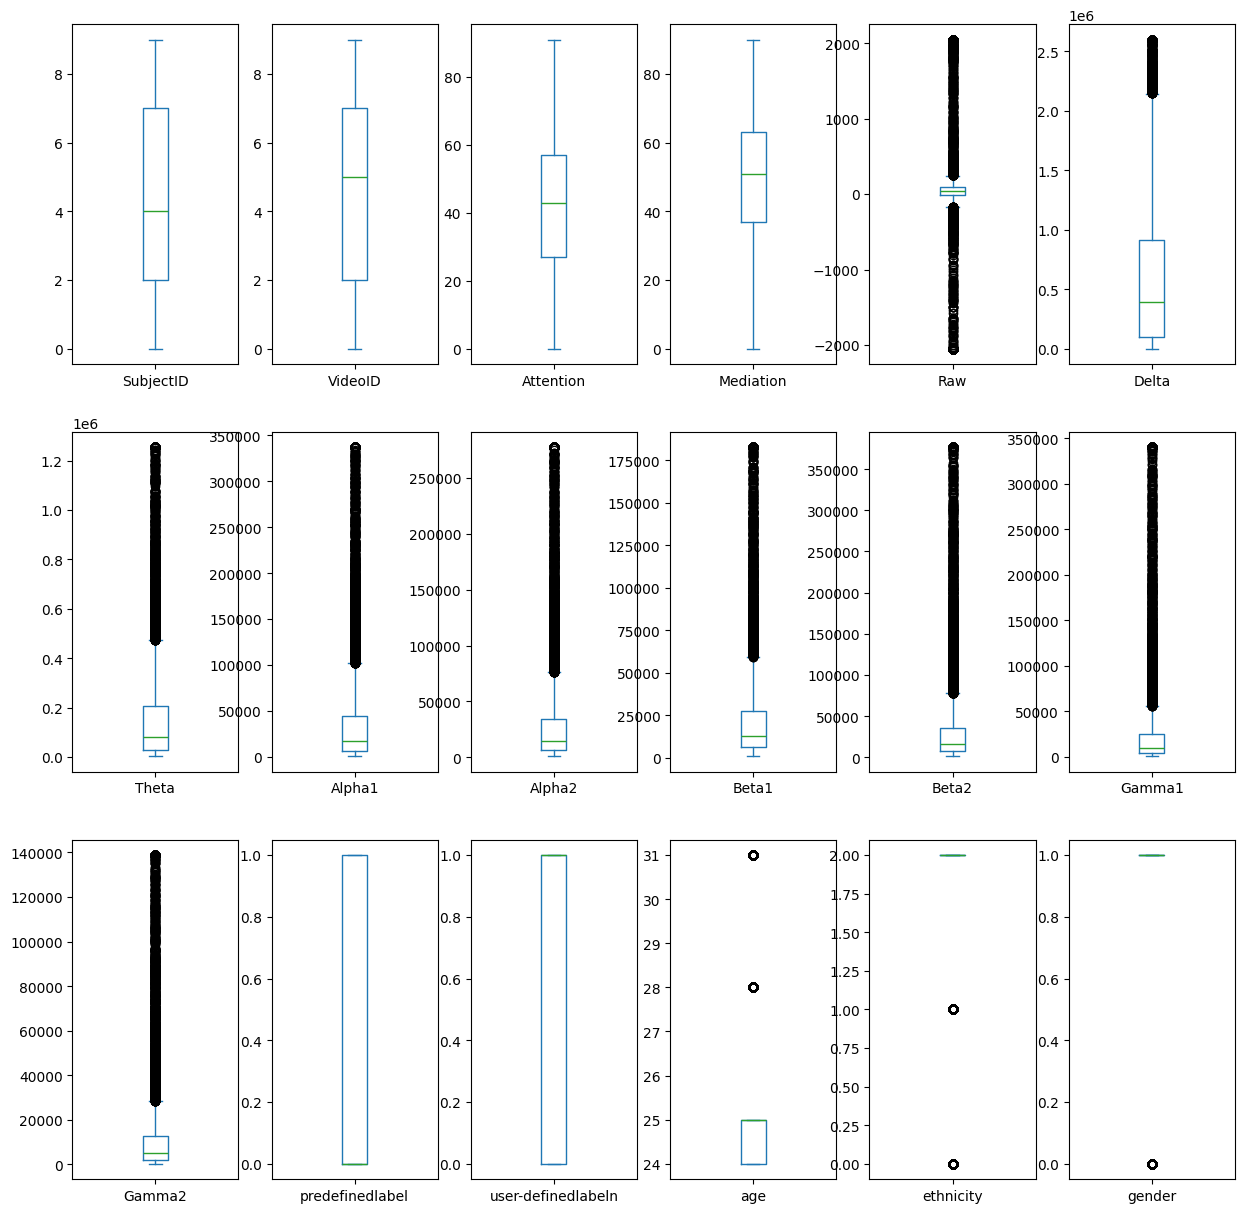

In [20]:
# Box-plot

data.plot(kind='box',figsize=(15,15),subplots=True,layout=(3,6))
plt.show()

### Target Distribution

In [21]:
data['user-definedlabeln'].value_counts()

,count
user-definedlabeln,
1.0,6567
0.0,6244


### Splitting the dataset based on user-defined labels

In [22]:
X =  data.drop(columns=['user-definedlabeln'])

In [23]:
y = data['user-definedlabeln']

In [24]:
print(X.shape,y.shape)

(12811, 17) (12811,)


In [25]:
print("Minimum value:", X.min())
print("Maximum value:", X.max())

Minimum value: SubjectID             0.0
VideoID               0.0
Attention             0.0
Mediation             0.0
Raw               -2048.0
Delta              2733.3
Theta              3410.0
Alpha1              750.0
Alpha2              981.3
Beta1               923.3
Beta2              1407.0
Gamma1              556.0
Gamma2              222.3
predefinedlabel       0.0
age                  24.0
ethnicity             0.0
gender                0.0
dtype: float64
Maximum value: SubjectID                9.0
VideoID                  9.0
Attention               91.0
Mediation               90.0
Raw                   2047.0
Delta              2595771.9
Theta              1253798.5
Alpha1              336929.3
Alpha2              277340.3
Beta1               182545.2
Beta2               376426.3
Gamma1              340048.0
Gamma2              138848.0
predefinedlabel          1.0
age                     31.0
ethnicity                2.0
gender                   1.0
dtype: float64


## Let's have a Correlation Matrix¶

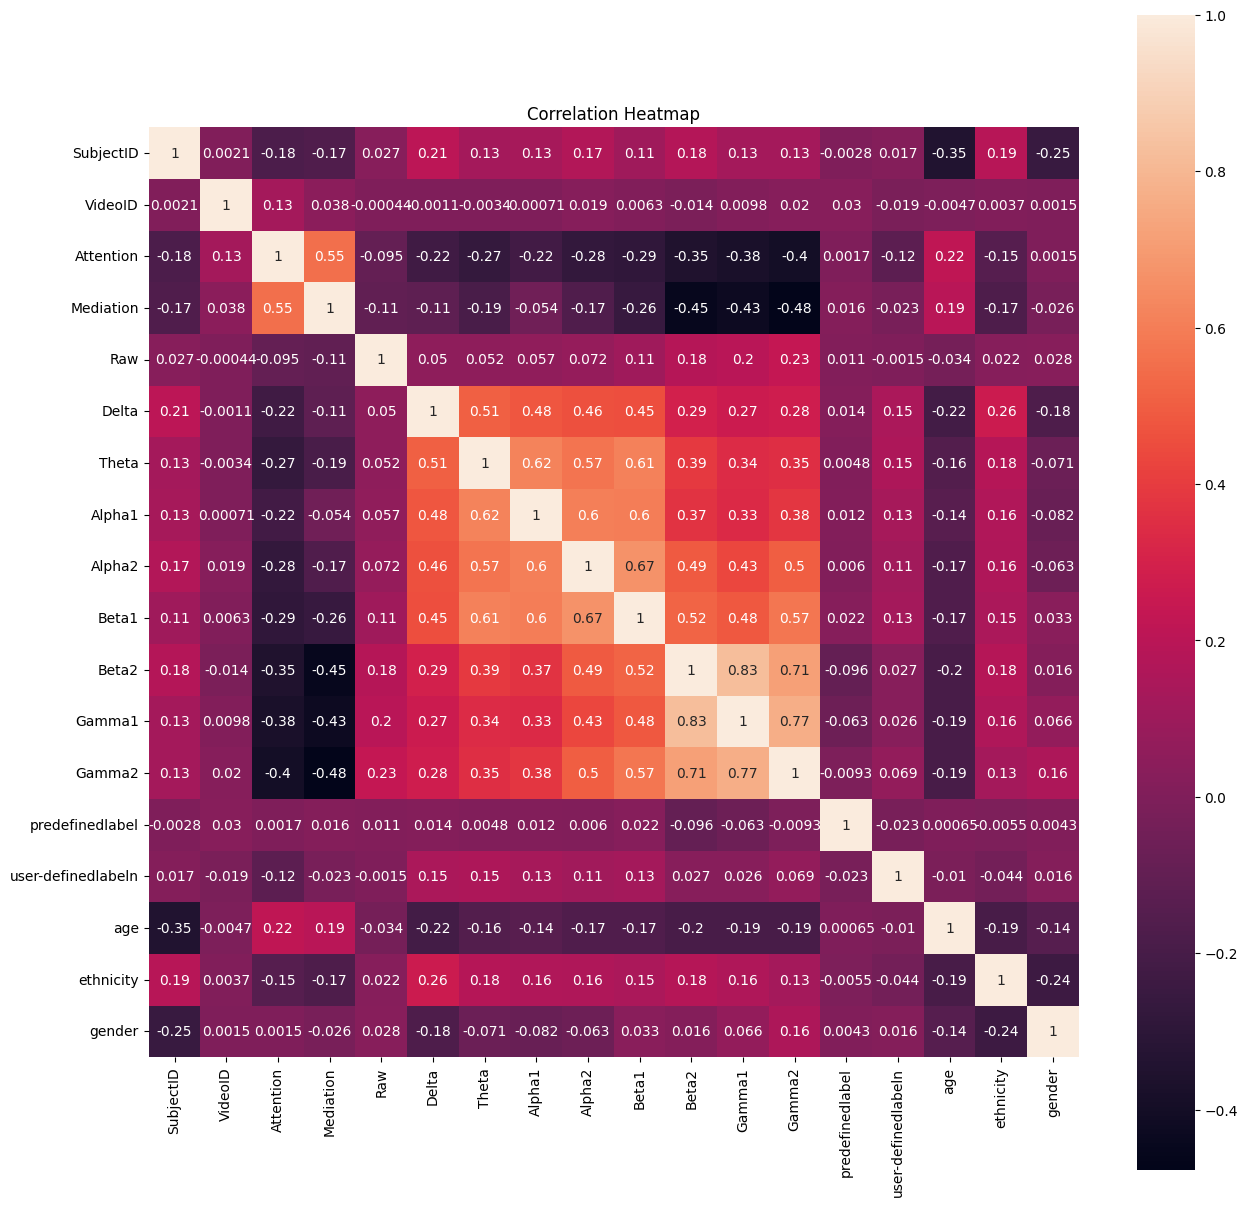

In [26]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, square=True)
plt.title('Correlation Heatmap')
plt.show()

As from the heatmap, We see there is a good correlation between Gamma1 and Beta2

### Feature information

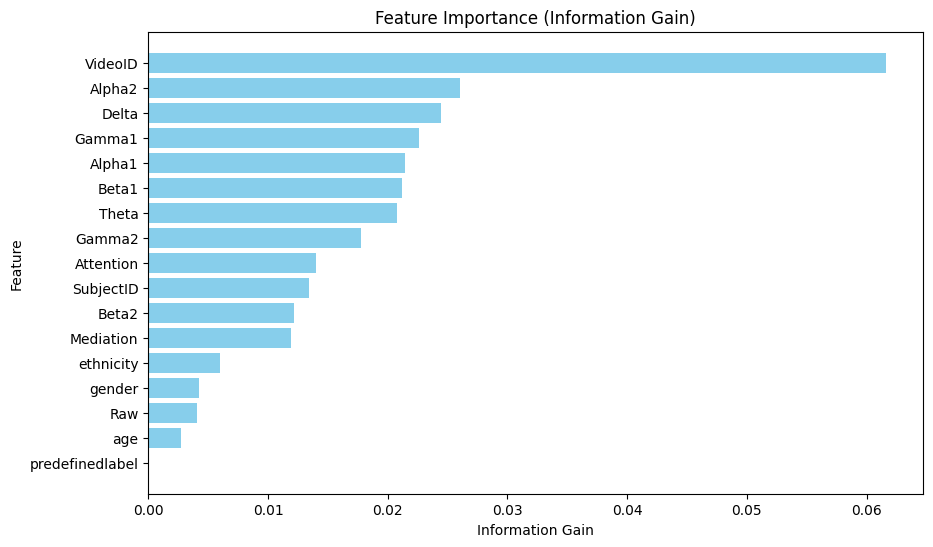

In [27]:
information_gain = mutual_info_classif(X, y)

# Create a DataFrame to store feature names and their information gain
feature_information_gain = pd.DataFrame({'Feature': X.columns,'Information_Gain': information_gain})

# Sort features by information gain in descending order
feature_information_gain = feature_information_gain.sort_values(
    by='Information_Gain', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_information_gain['Feature'],
         feature_information_gain['Information_Gain'], color='skyblue')
plt.xlabel('Information Gain')
plt.ylabel('Feature')
plt.title('Feature Importance (Information Gain)')
plt.gca().invert_yaxis()  # y-axis to have the highest information gain on top
plt.show()

In [28]:
# Create a DataFrame to store feature names and their information gain
feature_information_gain = pd.DataFrame({'Feature': X.columns, 'Information_Gain': information_gain})

# Sort features by information gain in descending order
feature_information_gain = feature_information_gain.sort_values(by='Information_Gain', ascending=False)

# Print the DataFrame
print("Feature Information Gain:")
print(feature_information_gain)

# Print the most important feature names
important_features = feature_information_gain['Feature'].tolist()
print("\nMost Important Features:")
print(important_features)

Feature Information Gain:
            Feature  Information_Gain
1           VideoID          0.061647
8            Alpha2          0.026029
5             Delta          0.024438
11           Gamma1          0.022636
7            Alpha1          0.021466
9             Beta1          0.021152
6             Theta          0.020741
12           Gamma2          0.017751
2         Attention          0.014038
0         SubjectID          0.013448
10            Beta2          0.012131
3         Mediation          0.011916
15        ethnicity          0.005989
16           gender          0.004246
4               Raw          0.004054
14              age          0.002715
13  predefinedlabel          0.000000

Most Important Features:
['VideoID', 'Alpha2', 'Delta', 'Gamma1', 'Alpha1', 'Beta1', 'Theta', 'Gamma2', 'Attention', 'SubjectID', 'Beta2', 'Mediation', 'ethnicity', 'gender', 'Raw', 'age', 'predefinedlabel']


Despite having high information gain, **VideoID** is being excluded to avoid the model overfitting to IDs and ensure it focuses on the desired features

In [29]:
df.drop(['SubjectID','predefinedlabel',"VideoID","ethnicity",'age','gender'], axis = 1,
        inplace=True)

In [30]:
X = StandardScaler().fit_transform(X)

We scale the  features to have a mean of 0 and a standard deviation of 1, which is a common practice to ensure that features are on a similar scale.

## Data Split

In [31]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=200)
# Reshapeing the data to 2D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

We have splitted the dataset into train and test into ration of 80/20

In [32]:
print("X Train Shape: ", X_train.shape)
print("Y Train Shape ",y_train.shape)

X Train Shape:  (10248, 17)
Y Train Shape  (10248,)


In [33]:
print("X Test Shape: ", X_test.shape)
print("Y Test Shape ",y_test.shape)

X Train Shape:  (2563, 17)
Y Train Shape  (2563,)


## Model Training

In [34]:
# Define common parameter values
n_estimators = [50, 100]
max_depth = [3, 5]
learning_rate = [0.01, 0.05, 0.1]
max_features = ['sqrt']
min_samples_split = [2, 5]
min_samples_leaf = [1, 2]

XGBoost is a powerful gradient boosting algorithm that excels in predictive performance and efficiency. It is known for its robustness to overfitting and ability to handle complex datasets.

Random Forest is an ensemble method that combines multiple decision trees to improve the model's accuracy and robustness. It is effective in handling high-dimensional data and can capture non-linear relationships.

Gradient Boosting builds models sequentially and each new model attempts to correct the errors made by the previous one. This method is effective in reducing bias and variance, leading to highly accurate models.


In [35]:
# Define the models and their parameter grids
models = [
    ('xgb', make_pipeline(StandardScaler(), xgb.XGBClassifier(objective='binary:logistic', seed=1)), {
        'xgbclassifier__n_estimators': n_estimators,
        'xgbclassifier__max_depth': max_depth,
        'xgbclassifier__learning_rate': learning_rate,
    }),
    ('rf', make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42)), {
        'randomforestclassifier__n_estimators': n_estimators,
        'randomforestclassifier__max_depth': [5, 10],
        'randomforestclassifier__max_features': max_features,
        'randomforestclassifier__min_samples_split': min_samples_split,
        'randomforestclassifier__min_samples_leaf': min_samples_leaf,
    }),
    ('gb', make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=42)), {
        'gradientboostingclassifier__n_estimators': n_estimators,
        'gradientboostingclassifier__max_depth': max_depth,
        'gradientboostingclassifier__learning_rate': [0.01, 0.1],  # for GradientBoostingClassifier
        'gradientboostingclassifier__max_features': max_features,
        'gradientboostingclassifier__min_samples_split': min_samples_split,
        'gradientboostingclassifier__min_samples_leaf': min_samples_leaf,
    })
]

In [37]:
import pickle

f1_scores = []
accuracy_scores = []
model_names = []
conf_matrices = []
precision_scores = []
recall_scores = []

for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print(f"\n{model_name.upper()} Results:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test)

    f1 = f1_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    model_names.append(model_name)
    conf_matrices.append(conf_matrix)
    precision_scores.append(precision)
    recall_scores.append(recall)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

    with open(f'best_{model_name}_model.pkl', 'wb') as file:
        pickle.dump(best_model, file)




XGB Results:
Best Parameters: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 100}
Best Score: 0.9971702555678558
Precision: 0.9947
Recall: 0.9992
Accuracy: 0.9969
F1 Score: 0.9970

RF Results:
Best Parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Best Score: 0.9146182432834579
Precision: 0.9065
Recall: 0.9521
Accuracy: 0.9251
F1 Score: 0.9287

GB Results:
Best Parameters: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 100}
Best Score: 0.9579436965087073
Precision: 0.9566
Recall: 0.9718
Accuracy: 0.962

The XGBoost model achieved the highest accuracy and F1 score among the three models, with an accuracy of 99.69% and an F1 score of 99.70%. This indicates that XGBoost performed exceptionally well in classifying the data.

Random Forest had slightly lower performance compared to XGBoost, with an accuracy of 92.51% and an F1 score of 92.87%. Despite this, Random Forest still performed reasonably well.
Gradient Boosting also showed good performance, with an accuracy of 95.94% and an F1 score of 96.08%.

Based on the results, the XGBoost model seems to be the most suitable choice due to its superior performance in terms of accuracy and F1 score. It achieved the highest accuracy while maintaining a low mean squared error, indicating robustness in classification.


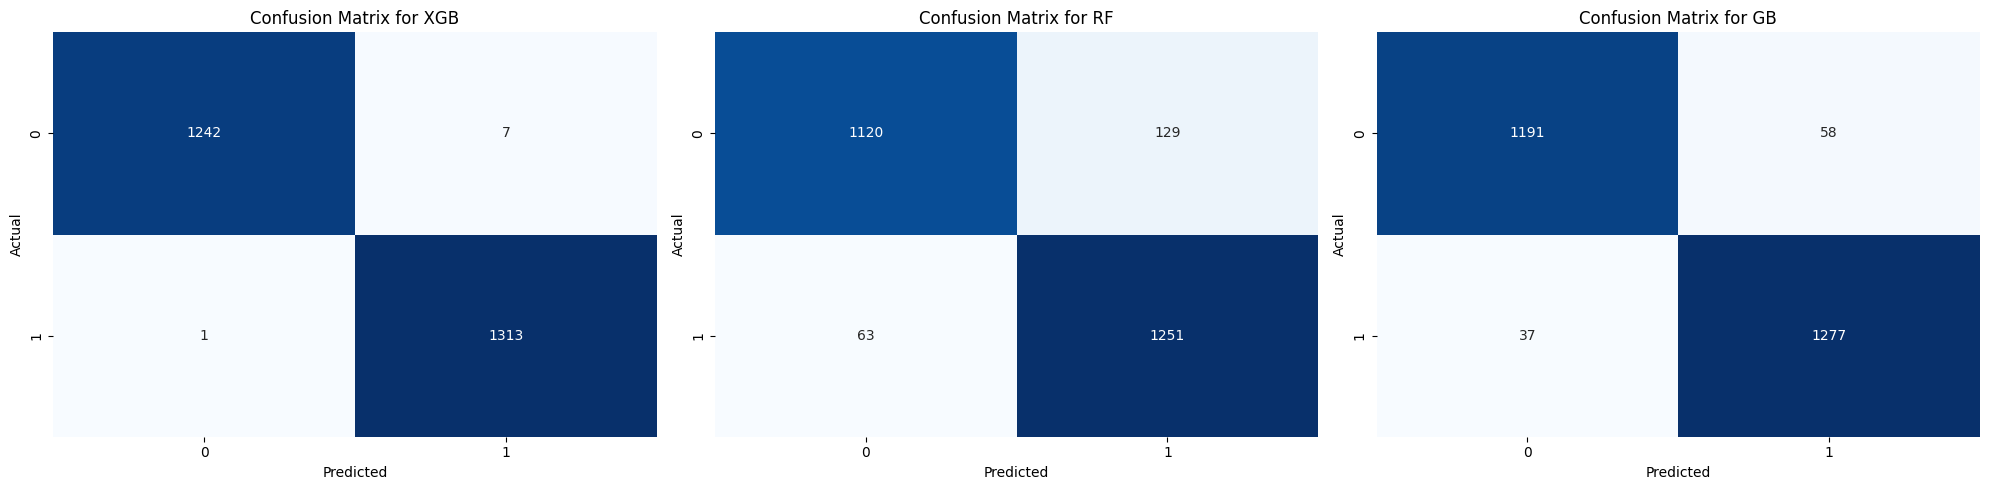

In [38]:
# Plot confusion matrices
num_models = len(models)
fig, axs = plt.subplots(1, num_models, figsize=(20, 5))

for i, (model_name, conf_matrix) in enumerate(zip(model_names, conf_matrices)):
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axs[i])
    axs[i].set_title(f'Confusion Matrix for {model_name.upper()}')
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

* All three models have high numbers of true positives (correctly classified
positives) and true negatives (correctly classified negatives), indicating strong predictive power.

* The XGBoost model has the fewest false positives and false negatives, with only 7 false positives and 1 false negative, demonstrating high precision and recall.

* The Random Forest model has a higher number of false positives (129) compared to XGBoost and Gradient Boosting, which may lead to a slightly lower precision.

* The Gradient Boosting model strikes a balance between the other two models, with slightly lower false positives (64) and false negatives (40) compared to Random Forest.

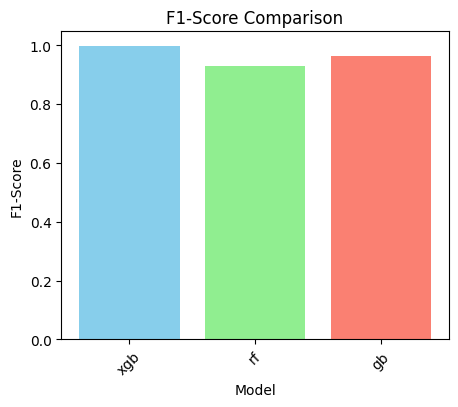

In [39]:
# Define colors for each model
colors = ['skyblue', 'lightgreen', 'salmon']

# Bar plot for F1-scores
plt.figure(figsize=(5, 4))
plt.bar(model_names, f1_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison')
plt.xticks(rotation=45)
plt.show()


xgb shows best f1 score

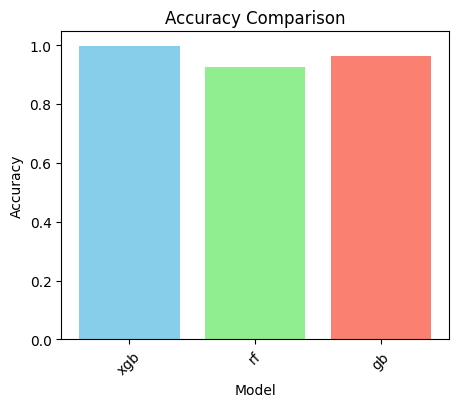

In [40]:
# Line plot for accuracy scores
colors = ['skyblue', 'lightgreen', 'salmon']
plt.figure(figsize=(5, 4))
plt.bar(model_names, accuracy_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

xgb showsmore accuracy wheras rf is less accurate than xgb and gb

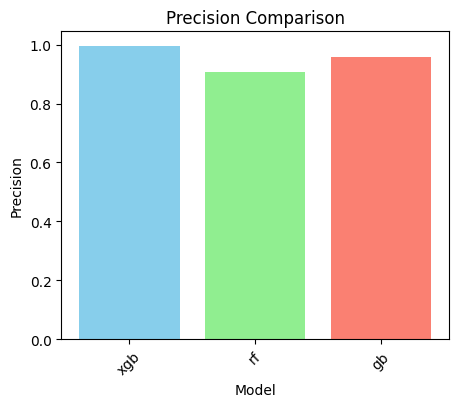

In [41]:
plt.figure(figsize=(5, 4))
plt.bar(model_names, precision_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.xticks(rotation=45)
plt.show()

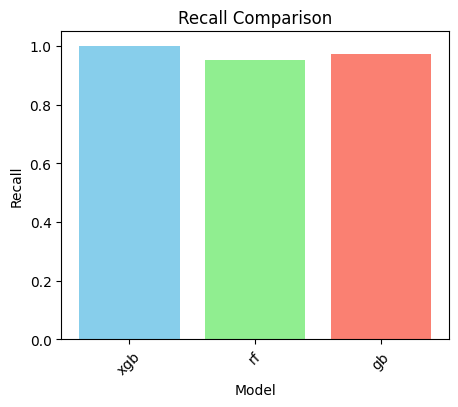

In [42]:
# Plotting recall scores
plt.figure(figsize=(5, 4))
plt.bar(model_names, recall_scores, color=colors)
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.xticks(rotation=45)
plt.show()

## Conclusion

In this project, we performed extensive **exploratory data analysis (EDA)** and **preprocessing** on the EEG dataset, followed by applying and evaluating multiple **ensemble methods**. Based on our analysis, the **GradientBoostingClassifier (XGB)** was found to be the most effective in predicting student confusion states, with an accuracy of **99.88%**.

Future work can involve incorporating more advanced **preprocessing techniques** and exploring additional models to further improve performance.
